<a href="https://colab.research.google.com/github/rahiakela/mathematics-for-machine-learning/blob/main/mathematics-for-machine-learning-and-data-science-specialization/03-probability-and-statistics/week1-probability-distributions/assignment_probability_distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Probability Distributions

Data plays a central role in various fields, including Data Science and Machine Learning Engineering. As time progresses, data has become increasingly crucial for making informed decisions and developing innovative products. In this assignment, you will work with data that follows different probability distributions.

**Sections**

1. **Generating Data**: Learn how to generate data that follows specific probability distributions.

2. **Naive Bayes Classifier (Continuous)**: Implement a Naive Bayes classifier for continuous data generated in Section 1.

3. **Real-Life Problem (Spam Detection)**: Enhance the Naive Bayes implementation to address a real-life problem, specifically spam detection.


##Setup

In [ ]:
!wget https://github.com/rahiakela/mathematics-for-machine-learning/raw/main/mathematics-for-machine-learning-and-data-science-specialization/03-probability-and-statistics/week1-probability-distributions/utils.py
!wget https://github.com/rahiakela/mathematics-for-machine-learning/raw/main/mathematics-for-machine-learning-and-data-science-specialization/03-probability-and-statistics/week1-probability-distributions/data/emails.csv

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
from scipy.special import erfinv
from scipy.stats import uniform, binom, norm
from dataclasses import dataclass
from sklearn.metrics import accuracy_score
import pprint
pp = pprint.PrettyPrinter()

import utils
from utils import (
    estimate_gaussian_params,
    estimate_binomial_params,
    estimate_uniform_params
)

## Section 1: Generating Data from a Specific Distribution

Let's recap some concepts and formalize them to facilitate coding. Don't worry, you will be guided throughout the entire assignment!

A random variable $X$ is a function that represents a random phenomenon, meaning its exact value cannot be determined. However, probabilities can be assigned to a set of possible values it can take. For example, if $X$ has a uniform distribution on $[2, 4]$, we cannot determine the exact value of $X$, but we can say with a probability of $1$ that the value lies between $[2, 4]$. We can also say that:

$$P(X \leq 3) = \frac{1}{2}$$

where $3$ is the midpoint of the interval $[2, 4]$. Therefore, you have learned that a random variable is associated with a function called the probability density function (pdf), which encodes the probability of the random variable falling within a given range. In other words, if $X$ is a continuous random variable and $f$ is its pdf, then:

$$P(a \leq X \leq b) = \text{Area of } f \text{ between } a \text{ and } b$$

In the discrete case, $P(X = a) = f(a)$. In any case, $P(-\infty < X < +\infty) = 1$ because a random variable is assumed to output real numbers.

Another function associated with a random variable is the cumulative distribution function (cdf), denoted as $F$. It represents the probability that a random variable $X$ will be less than or equal to $x$, for any $x \in \mathbb{R}$:

$$F(x) := P(X \leq x), \quad \forall x \in \mathbb{R}$$

The cdf is a non-decreasing function and approaches $1$ as $x$ approaches infinity because it represents a probability and must yield a value between $0$ and $1$.

In the lectures, you learned that if $X$ is a random variable with cdf $F$, then $F(X)$ follows a uniform distribution between $0$ and $1$. In other words, the new random variable $F(X)$ will be uniformly distributed between $0$ and $1$. This opens up the possibility of generating artificial data with any desired distribution, given that we know $F$. The process is as follows:

1. Generate a random value $y$ uniformly from the interval $[0, 1]$.
2. Compute $F^{-1}(y)$, which is the inverse function of $F$ evaluated at $y$.

It can be shown that if $Y$ follows a uniform distribution between $0$ and $1$, then the random variable $F^{-1}(Y)$ has the same distribution as $X$.

Therefore, by computing the inverse of $F$, you can generate artificial data from any known distribution! This is an incredibly powerful technique, isn't it?

So far in the course, you have encountered three common probability distributions:
- Uniform
- Binomial
- Gaussian

In the first part of this assignment, you will code a random generator for each of the above distributions!

### Exercise 1: Uniform Generator

The natural first step is to create a function capable of generating random data that comes from the uniform distribution. You will not be coding a [pseudo-random number generator](https://en.wikipedia.org/wiki/Pseudorandom_number_generator) (this is outside the scope of this assignment) but instead you will use a predefined function that handles this for you. If you are unsure where you can find such a function take a look at the [numpy.random.uniform](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html) function.

In [3]:
def uniform_generator(a, b, num_samples=100):
  """
  Generates an array of uniformly distributed random numbers within the specified range.

  Parameters:
  - a (float): The lower bound of the range.
  - b (float): The upper bound of the range.
  - num_samples (int): The number of samples to generate (default: 100).

  Returns:
  - array (ndarray): An array of random numbers sampled uniformly from the range [a, b).
  """
  np.random.seed(42)

  ### START CODE HERE ###
  X = np.random.uniform(a, b, num_samples)
  ### END CODE HERE ###

  return X

In [4]:
print(f"6 randomly generated values between 0 and 1:\n{np.array2string(uniform_generator(0, 1, num_samples=6), precision=3)}\n")
print(f"3 randomly generated values between 20 and 55:\n{np.array2string(uniform_generator(20, 55, num_samples=3), precision=3)}\n")
print(f"1 randomly generated value between 0 and 100:\n{np.array2string(uniform_generator(0, 100, num_samples=1), precision=3)}")

6 randomly generated values between 0 and 1:
[0.375 0.951 0.732 0.599 0.156 0.156]

3 randomly generated values between 20 and 55:
[33.109 53.275 45.62 ]

1 randomly generated value between 0 and 100:
[37.454]


**__Expected Output__**

```
6 randomly generated values between 0 and 1:
[0.375 0.951 0.732 0.599 0.156 0.156]

3 randomly generated values between 20 and 55:
[33.109 53.275 45.62 ]

1 randomly generated value between 0 and 100:
[37.454]
```

### Exercise 2:  Gaussian Generator

With your uniform data generator ready, you can go ahead and create generators for the other distributions. In order to do this you will need the inverse `CDF` for the distribution you wish to create data for.

#### 2.1 Inverse CDF - Gaussian

Let's start with a Normal Distribution generator. Usually, closed forms for CDFs are hard to obtain because they involve computing areas, which can be challenging.

In the Gaussian distribution, the closed formula uses a function called the Gaussian error function, denoted as $\text{erf}(x)$. However, you don't need to implement it or its inverse for this assignment. These functions are important in statistics, and there are many libraries available that provide their implementations.

For instance, you can use [scipy.special.erf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.erf.html) and [scipy.special.erfinv](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.erfinv.html#scipy.special.erfinv) to compute the erf function and its inverse. Alternatively, you can find an implementation of the erf function in [math.erf](https://docs.python.org/3/library/math.html#math.erf) from the Python math library.

If $X \sim N(\mu, \sigma)$, then the CDF $F(x)$ can be expressed as:

$$y = F(x) = \frac{1}{2} \left[ 1 + \text{erf}\left( \frac{x - \mu}{\sigma \sqrt{2}} \right) \right].$$

With some simple calculations and denoting ${\text{erf}}^{-1}$ as the inverse of the $\text{erf}$ function, it can be shown that:

$$x = F^{-1}(y) = \sigma \sqrt{2} \cdot \text{erf}^{-1}(2y - 1) + \mu.$$

In [5]:
def inverse_cdf_gaussian(y, mu, sigma):
  """
  Calculates the inverse cumulative distribution function (CDF) of a Gaussian distribution.

  Parameters:
  - y (float or ndarray): The probability or array of probabilities.
  - mu (float): The mean of the Gaussian distribution.
  - sigma (float): The standard deviation of the Gaussian distribution.

  Returns:
  - x (float or ndarray): The corresponding value(s) from the Gaussian distribution that correspond to the given probability/ies.
  """
  ### START CODE HERE ###
  x = mu + scipy.special.erfinv(2 * y - 1) * sigma * (2 ** 0.5)
  ### END CODE HERE ###
  return x

In [6]:
# Test your function
print(f"Inverse of Gaussian CDF with mu {15} and sigma {5} for value {1e-10}: {inverse_cdf_gaussian(1e-10, 15, 5):.3f}")
print(f"Inverse of Gaussian CDF with mu {15} and sigma {5} for value {0}: {inverse_cdf_gaussian(0, 15, 5)}")
print(f"Inverse of Gaussian CDF with mu {20} and sigma {0.5} for value {0.4}: {inverse_cdf_gaussian(0.4, 20, 0.5):.3f}")
print(f"Inverse of Gaussian CDF with mu {15} and sigma {5} for value {1}: {inverse_cdf_gaussian(1, 15, 5)}")

Inverse of Gaussian CDF with mu 15 and sigma 5 for value 1e-10: -16.807
Inverse of Gaussian CDF with mu 15 and sigma 5 for value 0: -inf
Inverse of Gaussian CDF with mu 20 and sigma 0.5 for value 0.4: 19.873
Inverse of Gaussian CDF with mu 15 and sigma 5 for value 1: inf


**__Expected Output__**

```
Inverse of Gaussian CDF with mu 15 and sigma 5 for value 1e-10: -16.807
Inverse of Gaussian CDF with mu 15 and sigma 5 for value 0: -inf
Inverse of Gaussian CDF with mu 20 and sigma 0.5 for value 0.4: 19.873
Inverse of Gaussian CDF with mu 15 and sigma 5 for value 1: inf
```

#### 2.2 Gaussian Generator

Now that you have all the necessary information, you can create a generator for data that follows a Gaussian distribution with a specified $\mu$ and $\sigma$. Similar to the generator for uniformly distributed data, the `gaussian_generator` function should allow you to specify the number of samples to generate. **Make sure to utilize the functions you have defined earlier in the assignment.**

In [7]:
def gaussian_generator(mu, sigma, num_samples):
  ### START CODE HERE ###
  # Generate an array with num_samples elements that distribute uniformally between 0 and 1
  uniform_dist = uniform_generator(0, 1, num_samples)

  # Use the uniform-distributed sample to generate Gaussian-distributed data
  # Hint: You need to sample from the inverse of the CDF of the distribution you are generating
  X = inverse_cdf_gaussian(uniform_dist, mu, sigma)
  ### END CODE HERE ###
  return X

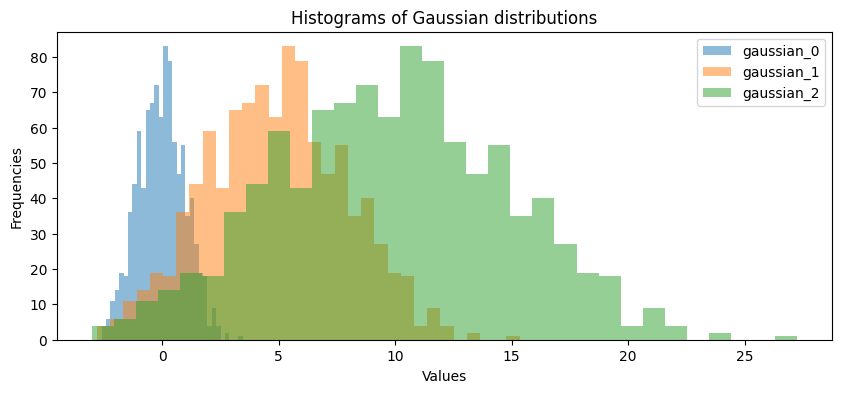

In [8]:
# Test your function
gaussian_0 = gaussian_generator(0, 1, 1000)
gaussian_1 = gaussian_generator(5, 3, 1000)
gaussian_2 = gaussian_generator(10, 5, 1000)

utils.plot_gaussian_distributions(gaussian_0, gaussian_1, gaussian_2)

**__Expected Output__**

<img src="https://github.com/rahiakela/mathematics-for-machine-learning/blob/main/mathematics-for-machine-learning-and-data-science-specialization/03-probability-and-statistics/week1-probability-distributions/images/gaussian.png?raw=1" style="height: 300px;"/>


### Exercise 3: Binomial Generator

#### 3.1 Inverse CDF - Binomial

If $X \sim \text{Binomial}(n,p)$, then its PDF is given by:

$$P(X = k) = {n \choose k}p^{k}(1-p)^{n-k}.$$

Therefore, if $0 \leq x \leq n$, its CDF is given by:

$$F(x) = P(X \leq x) = P(X = 0) + P(X = 1) + \ldots + P(X = \lfloor x \rfloor) = \sum_{k=0}^{\lfloor x \rfloor} {n \choose k}p^{k}(1-p)^{n-k}.$$

Here, $\lfloor x \rfloor$ denotes the [floor function](https://en.wikipedia.org/wiki/Floor_and_ceiling_functions), which returns the greatest integer less than or equal to $x$. For example, $\lfloor 2.9 \rfloor = 2$ and $\lfloor 1.2 \rfloor = 1$. This function is necessary because the domain of $F$ is the entire set of real numbers, but $P(X = k)$ is non-zero only for positive integer values.

If $x > n$, then $F(x) = 1$. It is important to note that the expression for $F(x)$ can become complex and messy, and there is no closed-form expression for the inverse function $F^{-1}$ in this case. However, statistical libraries provide implementations of the inverse CDF using [generalized quantile functions](https://en.wikipedia.org/wiki/Cumulative_distribution_function#Inverse_distribution_function_.28quantile_function.29). You can refer to [scipy.stats.binom](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html) for an example of a library that implements these functions. In particular, the `scipy.stats.binom.ppf` function is what you need. Since the `binom` class is already imported, you can use `help(binom)` to explore its parameters and functions. The function you will need is located in the "Methods" section: `ppf`.


In [9]:
def inverse_cdf_binomial(y, n, p):
  """
  Calculates the inverse cumulative distribution function (CDF) of a binomial distribution.

  Parameters:
  - y (float or ndarray): The probability or array of probabilities.
  - n (int): The number of trials in the binomial distribution.
  - p (float): The probability of success in each trial.

  Returns:
  - x (float or ndarray): The corresponding value(s) from the binomial distribution that correspond to the given probability/ies.
  """

  ### START CODE HERE ###
  x = binom.ppf(y, n, p)
  ### END CODE HERE ###

  return x

In [10]:
# Test your function
print(f"Inverse of Binomial CDF with n {15} and p {0.9} for value {1e-10}: {inverse_cdf_binomial(1e-10, 15, 0.9):.3f}")
print(f"Inverse of Binomial CDF with n {15} and p {0.5} for value {0}: {inverse_cdf_binomial(0, 15, 0.5)}")
print(f"Inverse of Binomial CDF with n {20} and p {0.2} for value {0.4}: {inverse_cdf_binomial(0.4, 20, 0.2):.3f}")
print(f"Inverse of Binomial CDF with n {15} and p {0.5} for value {1}: {inverse_cdf_binomial(1, 15, 0.5)}")

Inverse of Binomial CDF with n 15 and p 0.9 for value 1e-10: 3.000
Inverse of Binomial CDF with n 15 and p 0.5 for value 0: -1.0
Inverse of Binomial CDF with n 20 and p 0.2 for value 0.4: 3.000
Inverse of Binomial CDF with n 15 and p 0.5 for value 1: 15.0


**__Expected Output__**

```
Inverse of Binomial CDF with n 15 and p 0.9 for value 1e-10: 3.000
Inverse of Binomial CDF with n 15 and p 0.5 for value 0: -1.0
Inverse of Binomial CDF with n 20 and p 0.2 for value 0.4: 3.000
Inverse of Binomial CDF with n 15 and p 0.5 for value 1: 15.0
```

#### 3.2 Binomial Generator

In [11]:
def binomial_generator(n, p, num_samples):
  """
  Generates an array of binomially distributed random numbers.

  Args:
      n (int): The number of trials in the binomial distribution.
      p (float): The probability of success in each trial.
      num_samples (int): The number of samples to generate.

  Returns:
      array: An array of binomially distributed random numbers.
  """
  ### START CODE HERE ###

  # Generate an array with num_samples elements that distribute uniformally between 0 and 1
  uniform_gen = uniform_generator(0, 1, num_samples)
  # Use the uniform-distributed sample to generate binomial-distributed data
  # Hint: You need to sample from the inverse of the CDF of the distribution you are generating
  X = inverse_cdf_binomial(uniform_gen, n, p)
  ### END CODE HERE ###

  return X

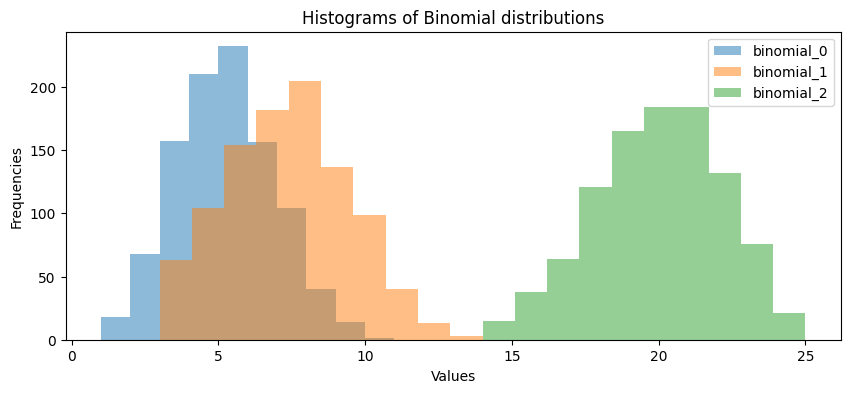

In [12]:
# Test your function
binomial_0 = binomial_generator(12, 0.4, 1000)
binomial_1 = binomial_generator(15, 0.5, 1000)
binomial_2 = binomial_generator(25, 0.8, 1000)

utils.plot_binomial_distributions(binomial_0, binomial_1, binomial_2)

**__Expected Output__**

<img src="https://github.com/rahiakela/mathematics-for-machine-learning/blob/main/mathematics-for-machine-learning-and-data-science-specialization/03-probability-and-statistics/week1-probability-distributions/images/binomial2.png?raw=1" style="height: 300px;"/>

## Section 2: Building a Dog Breed Classifier using Naive Bayes

In this section, you will utilize the generator functions to create features for a synthetic dataset containing information about three different dog breeds. Once you have prepared the dataset, your task is to implement the Naive Bayes algorithm to classify the dogs accurately based on their features.

### 2.1: Generating the Dataset

In this section, we will generate a dataset that consists of four features for each dog:

- `height` in centimeters, which follows a Gaussian distribution.
- `weight` in kilograms, which follows a Gaussian distribution.
- `bark_days`, representing the number of days (out of 30) that the dog barks. It follows a Binomial distribution with `n = 30`.
- `ear_head_ratio`, which is the ratio between the length of the ears and the length of the head. It follows a Uniform distribution.

We will generate synthetic data using the generator functions defined earlier to create a diverse and representative dataset for our dog breed classification problem.

In [13]:
FEATURES = ["height", "weight", "bark_days", "ear_head_ratio"]

Since the features follow different distributions and each one of these has different parameters you will create a `dataclass` for each one so you have an easy way of saving parameters. If you haven't used dataclasses before, don't worry, they are nothing complicated, you can think of them as containers for data in which you can access each variable by using the dot notation. So for example if you have:

```python
@dataclass
class my_data_class:
    my_var: str
        
foo = my_data_class(my_var="Hello World")
```

You can access the information of `my_var` from `foo` by using the syntax `foo.my_var`, which should be equal to "Hello World" in this example.

Dataclasses were introduced in Python 3.7 and are an excellent way of storing data (notice that it is a good practice when using them to specify the types of the data they store) so if you didn't know about them, you can start using them in your projects too. Also don't worry about the `__repr__` method, this only controls how many decimal points are printed out when you print an object of these dataclasses.

In [14]:
@dataclass
class GaussianDistribution:
    mu: float
    sigma: float

    def __repr__(self):
        return f"params_gaussian(mu={self.mu:.3f}, sigma={self.sigma:.3f})"


@dataclass
class BinomialDistribution:
    n: int
    p: float

    def __repr__(self):
        return f"params_binomial(n={self.n:.3f}, p={self.p:.3f})"


@dataclass
class UniformDistribution:
    a: int
    b: int

    def __repr__(self):
        return f"params_uniform(a={self.a:.3f}, b={self.b:.3f})"

Now that you have a place to store information about the parameters for different probability distributions you will define a dictionary that has the information for every breed of dogs:

In [15]:
breed_params = {
    0: {
        "height": GaussianDistribution(mu=35, sigma=1.5),
        "weight": GaussianDistribution(mu=20, sigma=1),
        "bark_days": BinomialDistribution(n=30, p=0.8),
        "ear_head_ratio": UniformDistribution(a=0.6, b=0.1)
    },
    1: {
        "height": GaussianDistribution(mu=35, sigma=2),
        "weight": GaussianDistribution(mu=25, sigma=5),
        "bark_days": BinomialDistribution(n=30, p=0.5),
        "ear_head_ratio": UniformDistribution(a=0.2, b=0.5)
    },
    2: {
        "height": GaussianDistribution(mu=40, sigma=3.5),
        "weight": GaussianDistribution(mu=32, sigma=3),
        "bark_days": BinomialDistribution(n=30, p=0.3),
        "ear_head_ratio": UniformDistribution(a=0.1, b=0.3)
    }
}

With the parameters and distributions for each breed defined you will generate the dataset. For this the `generate_data_for_breed` is provided for you.

Notice that this function uses a `match` statement which was introduced in Python 3.10 (the same version available in this environment) which allows this function to be written in a clear manner:

In [16]:
def generate_data_for_breed(breed, features, n_samples, params):
  """
  Generate synthetic data for a specific breed of dogs based on given features and parameters.

  Parameters:
      - breed (str): The breed of the dog for which data is generated.
      - features (list[str]): List of features to generate data for (e.g., "height", "weight", "bark_days", "ear_head_ratio").
      - n_samples (int): Number of samples to generate for each feature.
      - params (dict): Dictionary containing parameters for each breed and its features.

  Returns:
      - df (pandas.DataFrame): A DataFrame containing the generated synthetic data.
          The DataFrame will have columns for each feature and an additional column for the breed.
  """
  df = pd.DataFrame()

  for feature in features:
    match feature:
      case "height" | "weight":
        df[feature] = gaussian_generator(params[breed][feature].mu, params[breed][feature].sigma, n_samples)
      case "bark_days":
        df[feature] = binomial_generator(params[breed][feature].n, params[breed][feature].p, n_samples)
      case "ear_head_ratio":
        df[feature] = uniform_generator(params[breed][feature].a, params[breed][feature].b, n_samples)

  df["breed"] = breed

  return df

In [17]:
# Generate data for each breed
df_0 = generate_data_for_breed(breed=0, features=FEATURES, n_samples=1200, params=breed_params)
df_1 = generate_data_for_breed(breed=1, features=FEATURES, n_samples=1350, params=breed_params)
df_2 = generate_data_for_breed(breed=2, features=FEATURES, n_samples=900, params=breed_params)

# Concatenate all breeds into a single dataframe
df_all_breeds = pd.concat([df_0, df_1, df_2]).reset_index(drop=True)

# Shuffle the data
df_all_breeds = df_all_breeds.sample(frac = 1)

# Print the dataframe
df_all_breeds.head(10)

height     weight  bark_days  ear_head_ratio  breed
2836  39.697810  31.740980        9.0        0.193120      2
1002  36.710641  21.140427       26.0        0.163527      0
1075  34.726930  19.817954       24.0        0.386113      0
1583  37.324884  30.812210       18.0        0.463242      1
248   37.691499  21.794333       28.0        0.118190      0
814   36.688852  21.125901       26.0        0.165052      0
1407  35.844078  27.110196       16.0        0.399051      1
3376  38.616784  30.814387        8.0        0.169269      2
2700  44.655532  35.990456       12.0        0.281653      2
533   35.209095  20.139397       24.0        0.322284      0

All that is left is to divide the generated dataset into training and testing splits. You will use the 70% of the data for training and the remaining 30% for testing:

In [18]:
# Define a 70/30 training/testing split
split = int(len(df_all_breeds) * 0.7)

# Do the split
df_train = df_all_breeds[:split].reset_index(drop=True)
df_test = df_all_breeds[split:].reset_index(drop=True)

### 2.2 Naive Bayes Algorithm

Let's recap how the Naive Bayes algorithm works and formalize the notation.

Let $X$ be a set of training data. An element $x \in X$ is a vector in the form $x = (x_1, x_2, \ldots, x_n)$, where $n$ is the number of attributes of each sample. For instance, $X$ can be a set of 100 dog breeds, and each dog breed might have 3 attributes, such as ear head ratio, weight, and height. So, $X = \{ \text{dog}_1, \text{dog}_2, \ldots, \text{dog}_{100} \}$, and each dog breed, for instance, dog 5, will be represented as a 3-dimensional vector: $\text{dog}_5 = (\text{ear head ratio}_{\text{dog}_5}, \text{weight}_{\text{dog}_5}, \text{height}_{\text{dog}_5})$.

Suppose that there are $m$ classes $C_1, C_2, \ldots, C_m$. Using the same example above, suppose there are $m = 5$ different types of dog breeds in the training data. The idea is to predict the class of a sample $x \in X$ by looking at its attributes. Naive Bayes does so by computing the posterior probabilities of a sample belonging to class $C_i$, i.e., it computes

$$P(C_i \mid x), \quad i = 1, \ldots, m.$$

The predicted class is the $C_i$ with the highest probability. More formally, considering the set of every posterior probability of a given sample, what Naive Bayes computes is:

$$\text{predicted class for } x = \arg \max \left\{ P(C_1 \mid x), P(C_2 \mid x), \ldots, P(C_m \mid x) \right\}$$

So, if the highest value is $P(C_4 \mid x)$, then $\arg \max \left\{ P(C_1 \mid x), P(C_2 \mid x), \ldots, P(C_m \mid x) \right\} = 4$.

To compute the posterior probability $P(C_i \mid x)$, we use the Bayes' Theorem:

$$P(C_i \mid x) = \frac{P(x \mid C_i)P(C_i)}{P(x)}.$$

Note that $P(x)$ is positive and constant for every class $C_i$, therefore, to maximize $P(C_i \mid x)$, it is sufficient to maximize $P(x \mid C_i)P(C_i)$. The probabilities $P(C_i)$ are called the class prior probabilities, and they denote how likely a random sample from $X$ (without knowing any of its attributes) is to belong to each class. This value is usually not known and can be estimated from the training set by computing the proportion of each class in the training set. If the training set is too small, it is common to assume that each class is equally likely, i.e., $P(C_1) = P(C_2) = \ldots = P(C_m)$, thus only maximizing $P(x \mid C_i)$ remains. We will work with the more general case here.

In general, it would be computationally expensive to compute $P(x \mid C_i)$ for each $x$ and each class, this is why a **naive** assumption of **class-conditional independence** is made. This assumption states that each attribute is independent of each other attribute within each class. It is a strong assumption. For example, in our dog breed example, it would mean that for a specific type of dog breed, there is no correlation between its weight, height, and ear head ratio.

Assuming class-conditional independence, for an $x = (x_1, \ldots x_n)$ in $X$:

$$P(x \mid C_i) = P(x_1 \mid C_i) \cdot P(x_2 \mid C_i) \cdot \ldots \cdot P(x_n \mid C_i) = \prod_{k = 1}^{n} P(x_k \mid C_i).$$

The probabilities $P(x_k \mid C_i)$ can be estimated from the training data. The computation of $P(x_k \mid C_i)$ depends on whether $x_k$ is categorical or not.

- If $x_k$ is categorical, then $P(x_k \mid C_i)$ is the number of samples in $X$ that have attribute $x_k$ divided by the number of samples in class $C_i$.

- If $x_k$ is continuous-valued or discrete-valued, we need to make an assumption about its distribution and estimate its parameters using the training data. For instance, if $x_k$ is continuous-valued, we can assume that $P(x_k \mid C_i)$ follows a Gaussian distribution with parameters $\mu_{C_i}$ and $\sigma_{C_i}$. Therefore, we need to estimate $\mu$ and $\sigma$ from the training data, and then $P(x_k \mid C_i) = \text{PDF}_{\text{gaussian}}(x_k, \mu_{C_i}, \sigma_{C_i})$.

### Exercise 4: PDF for Distributions

To calculate the probabilities of predicting each class using Naive Bayes, you need to compute the prior probabilities. Although you already know the prior for each feature, you still need a way to compute the probability. In the next exercise, you are required to write a function that takes a value `x` and the relevant parameters and returns the value of the Probability Density Function (`PDF`) for each distribution.

You can choose to implement this function on your own or utilize the implementation from the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) module.

###### 4.1 Uniform PDF

If $X \sim \text{Uniform}(a,b)$, then the PDF for $X$ is given by:


$$f(x;a,b) =
\begin{cases}
\frac{1}{b-a}, \quad \text{if } x \in [a,b]. \\
0, \quad \text{otherwise.}
\end{cases}
$$

In [19]:
def pdf_uniform(x, a, b):
  """
  Calculates the probability density function (PDF) for a uniform distribution between 'a' and 'b' at a given point 'x'.

  Args:
      x (float): The value at which the PDF is evaluated.
      a (float): The lower bound of the uniform distribution.
      b (float): The upper bound of the uniform distribution.

  Returns:
      float: The PDF value at the given point 'x'. Returns 0 if 'x' is outside the range [a, b].
  """
  # ### START CODE HERE ###
  pdf = (0) if (x < a or x > b) else 1 / (b - a)
  ### END CODE HERE ###
  return pdf

In [20]:
# Test your function
print(f"Uniform PDF with a={0} and b={5} for value {1e-10}: {pdf_uniform(1e-10, 0, 5):.3f}")
print(f"Uniform PDF with a={20} and b={25} for value {5}: {pdf_uniform(5, 20, 25):.3f}")
print(f"Uniform PDF with a={2} and b={10} for value {5.4}: {pdf_uniform(5.4, 2, 10):.3f}")

Uniform PDF with a=0 and b=5 for value 1e-10: 0.200
Uniform PDF with a=20 and b=25 for value 5: 0.000
Uniform PDF with a=2 and b=10 for value 5.4: 0.125


**__Expected Output__**

```
Uniform PDF with a=0 and b=5 for value 1e-10: 0.200
Uniform PDF with a=20 and b=25 for value 5: 0.000
Uniform PDF with a=2 and b=10 for value 5.4: 0.125
```

##### 4.2 Gaussian PDF

You will need to implement the PDF for the Gaussian Distribution. The PDF for $X$ if $X \sim \text{Normal}(\mu,\sigma)$ is given by:

$$f(x;\mu,\sigma) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2}\left(\frac{x - \mu}{\sigma}\right)^2}$$

In [21]:
def pdf_gaussian(x, mu, sigma):
  """
  Calculate the probability density function (PDF) of a Gaussian distribution at a given value.

  Args:
      x (float or array-like): The value(s) at which to evaluate the PDF.
      mu (float): The mean of the Gaussian distribution.
      sigma (float): The standard deviation of the Gaussian distribution.

  Returns:
      float or ndarray: The PDF value(s) at the given point(s) x.
  """
  ### START CODE HERE ###
  coefficient = 1.0 / (sigma * np.sqrt(2 * np.pi))
  exponent = -0.5 * ((x - mu) / sigma) ** 2
  pdf = coefficient * np.exp(exponent)
  ### END CODE HERE ###
  return pdf

In [22]:
# Test your function
print(f"Gaussian PDF with mu={15} and sigma={5} for value {10}: {pdf_gaussian(10, 15, 5):.3f}")
print(f"Gaussian PDF with mu={15} and sigma={5} for value {0}: {pdf_gaussian(0, 15, 5):.3f}")
print(f"Gaussian PDF with mu={20} and sigma={0.5} for value {20}: {pdf_gaussian(20, 20, 0.5):.3f}")
print(f"Gaussian PDF with mu={15} and sigma={5} for value {1}: {pdf_gaussian(1, 15, 5):.3f}")

Gaussian PDF with mu=15 and sigma=5 for value 10: 0.048
Gaussian PDF with mu=15 and sigma=5 for value 0: 0.001
Gaussian PDF with mu=20 and sigma=0.5 for value 20: 0.798
Gaussian PDF with mu=15 and sigma=5 for value 1: 0.002


**__Expected Output__**

```
Gaussian PDF with mu=15 and sigma=5 for value 10: 0.048
Gaussian PDF with mu=15 and sigma=5 for value 0: 0.001
Gaussian PDF with mu=20 and sigma=0.5 for value 20: 0.798
Gaussian PDF with mu=15 and sigma=5 for value 1: 0.002
```

##### 4.3 Binomial Probability Mass Function (PMF)

For the binomial distribution, since it is a discrete distribution, we will be using the Probability Mass Function (PMF) instead of the Probability Density Function (PDF). However, for consistency, the graded function should still be named `pdf_binomial`.

Remember that if we have a random variable X following a binomial distribution with parameters n and p, its PMF is given by:
$$f(k; n, p) = {n \choose k}  p^k  (1-p)^{n-k}$$

Here, you can calculate the combination ${n \choose k}$ using either the definition: ${n \choose k} = \frac{n!}{k!(n-k)!}$, utilizing the `math.factorial` function, or you can use the `scipy.special.comb` function to obtain the combination. You can also refer to the `binom` documentation to find any other relevant functions that may assist you.

In [23]:
import math

def pmf_binomial(x, n, p):
  """
  Calculate the probability mass function (PMF) of a binomial distribution at a specific value.

  Args:
      x (int): The value at which to evaluate the PMF.
      n (int): The number of trials in the binomial distribution.
      p (float): The probability of success for each trial.

  Returns:
      float: The probability mass function (PMF) of the binomial distribution at the specified value.
  """
  ### START CODE HERE ###
  pmf = binom.pmf(x, n, p)
  # pmf = math.factorial(n) * (p ** x) * (1 - p) ** (n - x)
  ### END CODE HERE ###
  return pmf

In [24]:
# Test your function
print(f"Binomial PMF with n={15} and p={0.9} for value {15}: {pmf_binomial(15, 15, 0.9):.3f}")
print(f"Binomial PMF with n={30} and p={0.5} for value {15}: {pmf_binomial(15, 30, 0.5):.3f}")
print(f"Binomial PMF with n={20} and p={0.9} for value {15}: {pmf_binomial(15, 20, 0.9):.3f}")
print(f"Binomial PMF with n={15} and p={0.5} for value {20}: {pmf_binomial(20, 15, 0.5):.3f}")

Binomial PMF with n=15 and p=0.9 for value 15: 0.206
Binomial PMF with n=30 and p=0.5 for value 15: 0.144
Binomial PMF with n=20 and p=0.9 for value 15: 0.032
Binomial PMF with n=15 and p=0.5 for value 20: 0.000


**__Expected Output__**

```
Binomial PMF with n=15 and p=0.9 for value 15: 0.206
Binomial PMF with n=30 and p=0.5 for value 15: 0.144
Binomial PMF with n=20 and p=0.9 for value 15: 0.032
Binomial PMF with n=15 and p=0.5 for value 20: 0.000
```

### 2.3 Estimated Parameters

Now that you have the `PDF`s ready you need a way of estimating the parameters of the distributions for the features in the training split, this translates to estimating:

- `mu` and `sigma` for the `height` feature
- `mu` and `sigma` for the `weight` feature
- `n` and `p` for the `bark_days` feature
- `a` and `b` for the `ear_head_ratio` feature


Since the interpretation and way of computing these parameters has not been covered in the lectures, the assignment provides functions that can accomplish this for you. These have already been imported into this environment and are called:

- `estimate_gaussian_params`
- `estimate_binomial_params`
- `estimate_uniform_params`

All of these functions work in the same way. They expect an array of numbers (a numpy array, a pandas series or a regular python list) and will return the relevant parameters depending on the distribution selected. An example of how to use these functions can be seen by running the following cell:

In [25]:
m, s = estimate_gaussian_params(np.array([26.31, 32.45, 14.99]))
print(f"Gaussian:\nmu = {m:.3f} and sigma = {s:.3f} for sample: {np.array([26.31, 32.45, 14.99])}\n")

n, p = estimate_binomial_params(np.array([9, 26, 18, 14, 5]))
print(f"Binomial:\nn = {n} and p = {p:.3f} for sample: {np.array([9, 26, 18, 14, 5])}\n")

a, b = estimate_uniform_params(np.array([0.9, 0.26, 0.18, 0.07, 0.5]))
print(f"Uniform:\na = {a:.3f} and b = {b:.3f} for sample: {np.array([0.9, 0.26, 0.18, 0.07, 0.5])}")

Gaussian:
mu = 24.583 and sigma = 7.232 for sample: [26.31 32.45 14.99]

Binomial:
n = 30 and p = 0.480 for sample: [ 9 26 18 14  5]

Uniform:
a = 0.070 and b = 0.900 for sample: [0.9  0.26 0.18 0.07 0.5 ]


### Exercise 5: Computing parameters out of the training data

Now you have all the pieces you need to code the `compute_training_parameters` below. This function should receive a dataframe with the same structure as the one you generated at the beginning of this section and return two dictionaries:

- The first one (`params_dict`) should contain the estimated parameters of each feature for every breed. To be more concrete the first level should have the breeds (encoded as integers) as keys and the values should be another dictionary with the name of each feature as keys and with the estimated parameters saved within the relevant dataclass as values. To make this clearer, the end dictionary should end up looking like this:

```
{0: {'bark_days': params_dataclass(param1=x11, param2=x12),
     'ear_head_ratio': params_dataclass(param1=x21, param2=x22),
     'height': params_dataclass(param1=x31, param2=x32),
     'weight': params_dataclass(param1=x42, param2=x42)},
 1: ...     
}
```

- The second one (`probs_dict`) should include the proportion of data belonging to each breed. Notice that all values should sum up to 1. You can use Python's built-in `round` function to avoid very long floats but this is up to you and your grade will not be affected by this. This dict should look like this:

```
{0: 0.25, 1: 0.5, 2: 0.25}    
```

Notice that some structure has been pre-defined to help you out with the implementation. This structure uses a `match` statement but feel free to use any other way of coding this function (there are many ways to do it!). As long as the returning dictionaries contain the correct information, the implementation details won't affect your grade. As a reference for the `match` statement, you can access [here](https://peps.python.org/pep-0636/). Feel free to use `if-else` statement if you feel more comfortable with.

In [26]:
df_all_breeds.columns

Index(['height', 'weight', 'bark_days', 'ear_head_ratio', 'breed'], dtype='object')

In [27]:
def compute_training_params(df, features):
  """
  Computes the estimated parameters for training a model based on the provided dataframe and features.

  Args:
      df (pandas.DataFrame): The dataframe containing the training data.
      features (list): A list of feature names to consider.

  Returns:
      tuple: A tuple containing two dictionaries:
          - params_dict (dict): A dictionary that contains the estimated parameters for each breed and feature.
          - probs_dict (dict): A dictionary that contains the proportion of data belonging to each breed.
  """
  # Dict that should contain the estimated parameters
  params_dict = {}
  # Dict that should contain the proportion of data belonging to each class
  probs_dict = {}

  ### START CODE HERE ###
  # Loop over the breeds
  for breed in df_train["breed"]:
    # Slice the original df to only include data for the current breed and the feature columns
    # For reference in slicing with pandas, you can use the df_breed.groupby function followed by .get_group or you can use the syntax df[df['breed'] == group]
    df_breed = df_train[df_train["breed"] == breed][features]

    # Save the probability of each class (breed) in the probabilities dict
    # You can find the number of rows in a dataframe by using len(dataframe)
    probs_dict[breed] = len(df_breed) / len(df)

    # Initialize the inner dict
    inner_dict = {}

    # Loop over the columns of the sliced dataframe
    # You can get the columns of a dataframe like this: dataframe.columns
    for feature in df_breed.columns:
      match feature:
        case "height" | "weight":
          # Estimate parameters depending on the distribution of the current feature
          # and save them in the corresponding dataclass object
          mu = df_breed[feature].mean()
          sigma = df_breed[feature].std()
          params = GaussianDistribution(mu=mu, sigma=sigma)

        case "bark_days":
          # Estimate parameters depending on the distribution of the current feature
          # and save them in the corresponding dataclass object
          n = df_breed[feature].max()
          p = df_breed[feature].mean() / n
          params = BinomialDistribution(n=n, p=p)

        case "ear_head_ratio":
          # Estimate parameters depending on the distribution of the current feature
          # and save them in the corresponding dataclass object
          a = df_breed[feature].min()
          b = df_breed[feature].max()
          params = UniformDistribution(a=a, b=b)

      # Save the dataclass object within the inner dict
      inner_dict[feature] = params

    # Save inner dict within outer dict
    params_dict[breed] = inner_dict

  # ### END CODE HERE ###
  return params_dict, probs_dict

In [28]:
# Test your function
train_params, train_class_probs = compute_training_params(df_train, FEATURES)

print("Distribution parameters for training split:\n")
pp.pprint(train_params)
print("\nProbability of each class for training split:\n")
pp.pprint(train_class_probs)

Distribution parameters for training split:

{0: {'bark_days': params_binomial(n=30.000, p=0.801),
     'ear_head_ratio': params_uniform(a=0.100, b=0.597),
     'height': params_gaussian(mu=35.030, sigma=1.519),
     'weight': params_gaussian(mu=20.020, sigma=1.013)},
 1: {'bark_days': params_binomial(n=24.000, p=0.622),
     'ear_head_ratio': params_uniform(a=0.201, b=0.500),
     'height': params_gaussian(mu=34.971, sigma=2.011),
     'weight': params_gaussian(mu=24.927, sigma=5.028)},
 2: {'bark_days': params_binomial(n=18.000, p=0.493),
     'ear_head_ratio': params_uniform(a=0.101, b=0.300),
     'height': params_gaussian(mu=39.814, sigma=3.575),
     'weight': params_gaussian(mu=31.841, sigma=3.064)}}

Probability of each class for training split:

{0: 0.3461697722567288, 1: 0.39337474120082816, 2: 0.26045548654244305}


**__Expected Output__**

```
Distribution parameters for training split:

{0: {'bark_days': params_binomial(n=30.000, p=0.801),
     'ear_head_ratio': params_uniform(a=0.100, b=0.597),
     'height': params_gaussian(mu=35.030, sigma=1.518),
     'weight': params_gaussian(mu=20.020, sigma=1.012)},
 1: {'bark_days': params_binomial(n=30.000, p=0.498),
     'ear_head_ratio': params_uniform(a=0.201, b=0.500),
     'height': params_gaussian(mu=29.971, sigma=2.010),
     'weight': params_gaussian(mu=24.927, sigma=5.025)},
 2: {'bark_days': params_binomial(n=30.000, p=0.296),
     'ear_head_ratio': params_uniform(a=0.101, b=0.300),
     'height': params_gaussian(mu=39.814, sigma=3.572),
     'weight': params_gaussian(mu=31.841, sigma=3.061)}}

Probability of each class for training split:

{0: 0.346, 1: 0.393, 2: 0.26}
```

### Exercise 6: Compute the Probability of X given the Breed -> $P(x \mid C_{i})$

To code a Naive Bayes classifier, you will assume **class-conditional independence** for a given $x = (x_1, \ldots, x_n)$ in $X$. With this assumption, you can compute the probability of $x$ given the class using the following expression:

$$P(x \mid C_{i}) = P(x_1 \mid C_i) \cdot P(x_2 \mid C_i) \cdot \ldots \cdot P(x_n \mid C_i) = \prod_{k = 1}^{n} P(x_k \mid C_i).$$

The probabilities $P(x_k \mid C_i)$ can be estimated from the training tuples.

If $x_k$ is continuous-valued or discrete-valued, you need to make an assumption about its distribution and estimate its parameters using the training set. For example, if $x_k$ is continuous-valued, it is often assumed that $P(x_k \mid C_i)$ follows a Gaussian distribution with parameters $\mu_{C_i}$ and $\sigma_{C_i}$. Therefore, you need to estimate $\mu$ and $\sigma$ from the training set, and then $P(x_k \mid C_i) = \text{PDF}_{\text{gaussian}}(x_k,\mu_{C_i},\sigma_{C_i})$.

In this case, you already know the true distributions for every feature, so you just need to compute the appropriate `PDF` for each feature by passing the estimated parameters of that feature to the corresponding `PDF` computation function.

Complete the `prob_of_X_given_C` function below. This function takes the following parameters:
- `X`: a list containing the values for the features in the `features` parameter (the order matters)
- `features`: the names of the features being passed
- `breed`: the breed that will be assumed for the `X` observation
- `params_dict`: the dictionary containing the estimated parameters from the training split

The function should return the probability of the values of `X` given the selected `breed`.


In [29]:
def prob_of_X_given_C(X, features, breed, params_dict):
  """
  Calculate the conditional probability of X given a specific breed, using the given features and parameters.

  Args:
      X (list): List of feature values for which the probability needs to be calculated.
      features (list): List of feature names corresponding to the feature values in X.
      breed (str): The breed for which the probability is calculated.
      params_dict (dict): Dictionary containing the parameters for different breeds and features.

  Returns:
      float: The conditional probability of X given the specified breed.
  """
  if len(X) != len(features):
    print("X and list of features should have the same length")
    return 0

  probability = 1.0

  ### START CODE HERE ###
  for x, feature in zip(X, features):
    # Get the relevant parameters from params_dict
    params = params_dict[breed][feature]
    match feature:
      # You can add add as many case statements as you see fit
      case "height" | "weight":
        # Compute the relevant pdf given the distribution and the estimated parameters
        probability_f = pdf_gaussian(x, params.mu, params.sigma)
      case "bark_days":
        probability_f = pmf_binomial(x, params.n, params.p)
      case "ear_head_ratio":
        probability_f = pdf_uniform(x, params.a, params.b)

    #  Multiply by probability of current feature
    probability *= probability_f
  ### END CODE HERE ###
  return probability

In [30]:
# Test your function
example_dog = df_test[FEATURES].loc[0]
example_breed = df_test[["breed"]].loc[0]["breed"]
print(f"Example dog has breed {example_breed} and features: height = {example_dog['height']:.2f}, weight = {example_dog['weight']:.2f}, bark_days = {example_dog['bark_days']:.2f}, ear_head_ratio = {example_dog['ear_head_ratio']:.2f}\n")

print(f"Probability of these features if dog is classified as breed 0: {prob_of_X_given_C([*example_dog], FEATURES, 0, train_params)}")
print(f"Probability of these features if dog is classified as breed 1: {prob_of_X_given_C([*example_dog], FEATURES, 1, train_params)}")
print(f"Probability of these features if dog is classified as breed 2: {prob_of_X_given_C([*example_dog], FEATURES, 2, train_params)}")

Example dog has breed 1 and features: height = 33.63, weight = 21.56, bark_days = 13.00, ear_head_ratio = 0.27

Probability of these features if dog is classified as breed 0: 3.328493789988861e-07
Probability of these features if dog is classified as breed 1: 0.003942085319420158
Probability of these features if dog is classified as breed 2: 1.7290651869884347e-06


**__Expected Output__**

```
Example dog has breed 1 and features: height = 28.63, weight = 21.56, bark_days = 13.00, ear_head_ratio = 0.27

Probability of these features if dog is classified as breed 0: 6.989632718589114e-11
Probability of these features if dog is classified as breed 1: 0.0038267778327024894
Probability of these features if dog is classified as breed 2: 7.959172138800559e-08
```

### Exercise 7: Predict the Breed

If all classes were perfectly balanced, the previous function could be used to compute the maximum posterior. However, this is NOT the case, and you still need to multiply every probability $P(x \mid C_{i})$ by the probability of belonging to each class $P(C_{i})$. After all, the expression that you need to maximize in order to get a prediction is $P(x \mid C_{i})P(C_{i})$. You can accomplish this by multiplying the result of `prob_of_X_given_C` by the corresponding proportion found in the `probs_dict` dictionary.

Complete the `predict_breed` function below. This function receives the following parameters:
- `X`: a list containing the values for the features of each feature in the `features` parameter (the order matters).
- `features`: the name of the features being passed.
- `params_dict`: the dictionary containing the estimated parameters from the training split.
- `probs_dict`: the dictionary containing the proportion of each class from the training split.

The function should return the breed with the highest maximum posterior:

In [31]:
def predict_breed(X, features, params_dict, probs_dict):
  """
  Predicts the breed based on the input and features.

  Args:
      X (array-like): The input data for prediction.
      features (array-like): The features used for prediction.
      params_dict (dict): A dictionary containing parameters for different breeds.
      probs_dict (dict): A dictionary containing probabilities for different breeds.

  Returns:
      int: The predicted breed index.
  """
  ### START CODE HERE ###
  posterior_breed_0 = prob_of_X_given_C(X, features, 0, params_dict) * probs_dict[0]
  posterior_breed_1 = prob_of_X_given_C(X, features, 1, params_dict) * probs_dict[1]
  posterior_breed_2 = prob_of_X_given_C(X, features, 2, params_dict) * probs_dict[2]
  # Save the breed with the maximum posterior
  # Hint: You can create a numpy array with the posteriors and then use np.argmax
  posterior_array = np.array([posterior_breed_0, posterior_breed_1, posterior_breed_2])
  prediction = np.argmax(posterior_array)
  ### END CODE HERE ###
  return prediction

In [32]:
# Test your function
example_pred = predict_breed([*example_dog], FEATURES, train_params, train_class_probs)
print(f"Example dog has breed {example_breed} and Naive Bayes classified it as {example_pred}")

Example dog has breed 1 and Naive Bayes classified it as 1


**__Expected Output__**

```
Example dog has breed 1 and Naive Bayes classified it as 1
```

The classifier worked for this particular example, but how will it perform when considering the whole testing split?

Run the following cell to find out:

In [33]:
preds = df_test.apply(lambda x: predict_breed([*x[FEATURES]], FEATURES, train_params, train_class_probs), axis=1)
test_acc = accuracy_score(df_test["breed"], preds)
print(f"Accuracy score for the test split: {test_acc:.2f}")

Accuracy score for the test split: 1.00


**__Expected Output__**

```
Accuracy score for the test split: 1.00
```

The Naive Bayes classifier achieved an accuracy of 100% in the testing data. Nice job!

You might think that something is wrong when reaching such a high accuracy but in this case it makes sense because the data is generated and you know the true distributions for each feature, real-life data won't have this nice behavior!

## Section 3 - Spam Detector

In this final section you will once again implement and train a Naive Bayes classifier. The idea is to build a classifier that is able to detect spam from ham (aka not spam) emails. This time your implementation should take into account two major differences:

- The data is a real life dataset that includes over 5500 emails with their corresponding labels
- The features are categorical

Begin by loading the dataset and doing some pre-processing:

In [36]:
# Load the dataset
emails = pd.read_csv("emails.csv")
emails.head()

text  spam
0  Subject: naturally irresistible your corporate...     1
1  Subject: the stock trading gunslinger  fanny i...     1
2  Subject: unbelievable new homes made easy  im ...     1
3  Subject: 4 color printing special  request add...     1
4  Subject: do not have money , get software cds ...     1

In [37]:
# Helper function that converts text to lowercase and splits words into a list
def process_email(text):
  """
  Processes the given email text by converting it to lowercase, splitting it into words, and returning a list of unique words.

  Parameters:
  - text (str): The email text to be processed.

  Returns:
  - list: A list of unique words extracted from the email text.
  """
  text = text.lower()
  return list(set(text.split()))

In [38]:
# Create an extra column with the text converted to a lower-cased list of words
emails["words"] = emails["text"].apply(process_email)

# Show the first 5 rows
emails.head()

text  spam  \
0  Subject: naturally irresistible your corporate...     1   
1  Subject: the stock trading gunslinger  fanny i...     1   
2  Subject: unbelievable new homes made easy  im ...     1   
3  Subject: 4 color printing special  request add...     1   
4  Subject: do not have money , get software cds ...     1   

                                               words  
0  [_, structure, management, but, and, :, look, ...  
1  [hawthorn, huzzah, sapling, hall, try, merrill...  
2  [opportunity, advantage, credit, pre, at, home...  
3  [advertisement, canyon, an, graphix, here, ord...  
4  [', here, compatibility, money, have, ., all, ...

### One last Naive Bayes reminder

Remember that supposing **class-conditional independence**, for a $x = (x_1, \ldots x_n)$ in $X$:

$$P(x \mid C_{i}) = P(x_1 \mid C_i) \cdot P(x_2 \mid C_i) \cdot \ldots \cdot P(x_n \mid C_i) = \prod_{k = 1}^{n} P(x_k \mid C_i).$$

The probabilities $P(x_k\mid C_i)$ can be estimated from the training tuples. The computation of $P(x_k \mid C_i)$ depends on whether $x_k$ is categorical or not.

If $x_k$ is categorical, then $P(x_k \mid C_i)$ is the number of samples in $X$ that has attribute $x_k$ divided by the number of samples in class $C_i$.

With this in mind, you need to know the number of times that each word appears in both spam and ham emails, as well as the number of samples for class. Your next two exercises will be about computing these values.

**Note:** If you need some extra help for this implementation be sure to check out this amazing [tutorial](https://www.youtube.com/watch?v=Q8l0Vip5YUw) by your instructor Luis.

### Exercise 8: Frequency of a word in each class

To compute the frequency of each word in the dataset you need to define the `word_freq_per_class` below. This function receives the email dataframe as input and should return a dictionary that has the words in the emails as keys and another dictionary that keeps track of how many times that word appeared in `spam` and `hams` emails as values. This dictionary should look like this:

```python
{'website': {'spam': 204, 'ham': 135},
 'collaboration': {'spam': 28, 'ham': 34},
 'logo': {'spam': 97, 'ham': 13},
 ...
}
```